# LMS Analytics Demo (5 charts)

Dùng dữ liệu mẫu trong `LMS/db/sample_data` (tạo bởi `generate_fake_data.py`) và vẽ 5 chart trùng với UI:
1) Course KPI time-series (active users, submissions, completions, avg grade)
2) Grade distribution histogram
3) Active users over time (all courses)
4) Submission latency (histogram + avg per activity)
5) User engagement (top users by events)

Yêu cầu: pandas, matplotlib, seaborn.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid')

def resolve_data_dir():
    cwd = Path.cwd()
    cand = cwd / 'LMS' / 'db' / 'sample_data'
    if cand.exists():
        return cand
    cand = cwd.parent / 'db' / 'sample_data'
    if cand.exists():
        return cand
    raise FileNotFoundError('Run generate_fake_data.py to create data first')

DATA_DIR = resolve_data_dir()
print('Using data dir:', DATA_DIR)

user_dim = pd.read_csv(DATA_DIR / 'user_dim.csv')
course_dim = pd.read_csv(DATA_DIR / 'course_dim.csv')
enrol_fact = pd.read_csv(DATA_DIR / 'enrol_fact.csv', parse_dates=['enrol_time'])
grade_fact = pd.read_csv(DATA_DIR / 'grade_fact.csv', parse_dates=['graded_at'])
submission_fact = pd.read_csv(DATA_DIR / 'submission_fact.csv', parse_dates=['submitted_at','duedate'])
event_log = pd.read_csv(DATA_DIR / 'event_log_staging.csv')
daily_kpi = pd.read_csv(DATA_DIR / 'daily_course_kpi.csv')
daily_kpi['date'] = pd.to_datetime(daily_kpi['date'])

display(user_dim.head(), course_dim.head(), daily_kpi.head())

Using data dir: c:\xampp\htdocs\moodle\LMS\db\sample_data


,id,moodle_userid,name,role,org,created_at
0,1,1001,Alex Hoang,student,OrgA,2025-11-22T22:11:36.147150
1,2,1002,Sam Bui,student,OrgA,2025-08-20T22:11:36.147150
2,3,1003,Alex Tran,student,OrgA,2025-11-20T22:11:36.147150
3,4,1004,Alex Bui,student,OrgA,2025-07-19T22:11:36.147150
4,5,1005,Riley Do,student,OrgA,2025-09-26T22:11:36.147150


,id,moodle_courseid,fullname,category,startdate
0,1,2001,DevOps Bootcamp 1,Biz,2025-11-08
1,2,2002,Mobile Bootcamp 2,Tech,2025-11-11
2,3,2003,Cloud Bootcamp 3,Biz,2025-12-15
3,4,2004,Cloud Bootcamp 4,Tech,2025-12-04
4,5,2005,Frontend Bootcamp 5,Biz,2025-09-30


,course_id,date,active_users,submissions,completions,avg_grade
0,1,2025-11-17,37,9,11,0.0
1,1,2025-12-05,20,3,5,0.0
2,1,2025-11-08,50,8,11,0.0
3,1,2025-11-13,39,13,9,0.0
4,1,2025-11-29,48,9,8,0.0


## 1) Course KPI time-series
**Course KPIs over time** (active users, submissions, completions, avg grade): quick health check of engagement and learning outcomes by day.

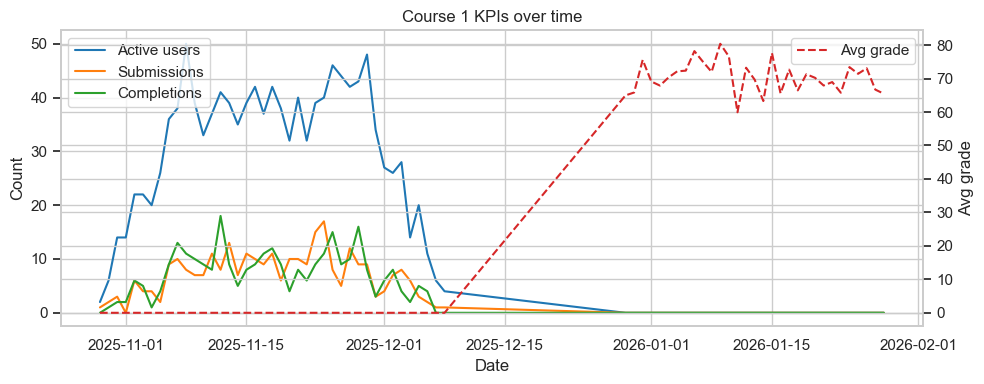

In [3]:
cid = daily_kpi['course_id'].iloc[0]
df = daily_kpi[daily_kpi['course_id'] == cid].sort_values('date')
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(df['date'], df['active_users'], label='Active users', color='tab:blue')
ax1.plot(df['date'], df['submissions'], label='Submissions', color='tab:orange')
ax1.plot(df['date'], df['completions'], label='Completions', color='tab:green')
ax2 = ax1.twinx()
ax2.plot(df['date'], df['avg_grade'], label='Avg grade', color='tab:red', linestyle='--')
ax1.set_title(f'Course {cid} KPIs over time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Count')
ax2.set_ylabel('Avg grade')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 2) Grade distribution histogram
**Grade distribution histogram**: see difficulty/fairness of assessments and detect skew/outliers.

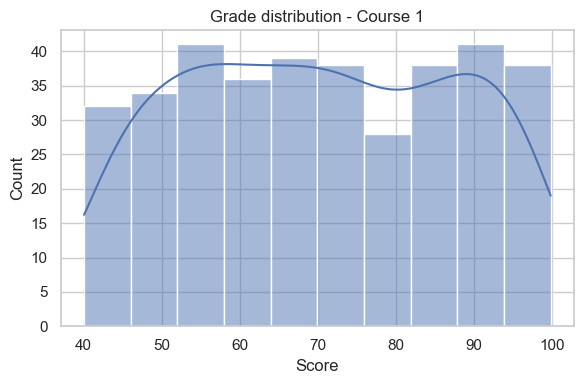

In [4]:
cid = grade_fact['course_id'].iloc[0]
g = grade_fact[grade_fact['course_id'] == cid]
plt.figure(figsize=(6,4))
sns.histplot(g['score'], bins=10, kde=True)
plt.title(f'Grade distribution - Course {cid}')
plt.xlabel('Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 3) Active users over time (all courses)
**Active users trend**: isolates login/visit volume to spot adoption spikes or drops independently from grades.

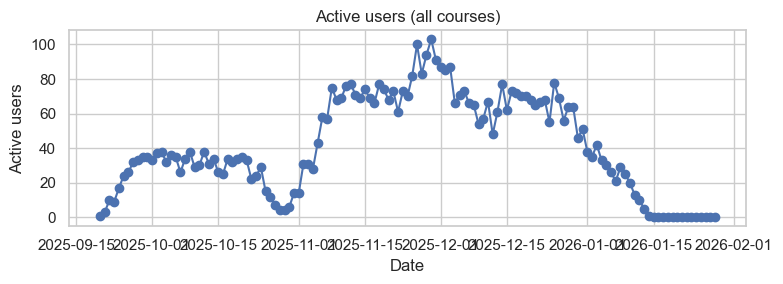

In [5]:
active_series = daily_kpi.groupby('date')['active_users'].sum().reset_index().sort_values('date')
plt.figure(figsize=(8,3))
plt.plot(active_series['date'], active_series['active_users'], marker='o')
plt.title('Active users (all courses)')
plt.xlabel('Date')
plt.ylabel('Active users')
plt.tight_layout()
plt.show()

## 4) Submission latency
**Submission latency per activity**: measures how early/late learners submit to flag overload or deadline issues.


In [ ]:
sub_series = submission_fact.copy()
latency_hours = (sub_series['submitted_at'] - sub_series['duedate']).dt.total_seconds() / 3600
sub_series['latency_hours'] = latency_hours

plt.figure(figsize=(6,3))
sns.histplot(latency_hours, bins=20, kde=True)
plt.title('Submission latency (hours)')
plt.xlabel('Hours late (neg = early)')
plt.tight_layout()
plt.show()

latency_per_activity = sub_series.groupby('activity_id')['latency_hours'].mean().reset_index()
plt.figure(figsize=(6,))
sns.barplot(data=latency_per_activity, x='activity_id', y='latency_hours', palette='crest')
plt.title('Avg latency per activity')
plt.xlabel('Activity ID')
plt.ylabel('Avg hours late')
plt.tight_layout()
plt.show()

NameError: name 'submission_fact' is not defined

## 5) User engagement (top users by events)
**Event frequency by window** (log bucket chart): highlights behavioral bursts / quiet periods in raw event stream for anomaly 

C:\Users\minhs\AppData\Local\Temp\ipykernel_20760\2230283730.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, x='user_id', y='events_count', palette='mako')


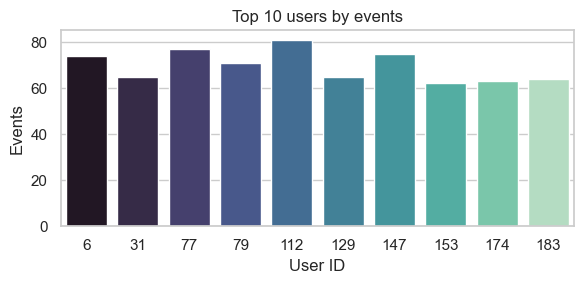

In [7]:
events_per_user = event_log.groupby('user_id').size().reset_index(name='events_count')
top_users = events_per_user.nlargest(10, 'events_count')
plt.figure(figsize=(6,3))
sns.barplot(data=top_users, x='user_id', y='events_count', palette='mako')
plt.title('Top 10 users by events')
plt.xlabel('User ID')
plt.ylabel('Events')
plt.tight_layout()
plt.show()